# Physics Informed Neural Network for unsteady 1D Shock Problem

# Objective

* To use a Neural Network (NN) to predict an inviscid one-dimensional unsteady compressible shock flow.

* To train the NN based on the input parameters: x and t and accurately predict *density* (rho), *pressure* (P), *velocity* (u) and *specific energy* (E) at that point. This would just give an ordinary deep learning network trained entirely based on the data, acting as a black box which just takes 2 inputs and produces 4 outputs. What we want is a Physics Informed Neural Network (PINN), that is, enforce the constrains defined by the governing equations by adding another term to the loss function.

## Governing conservative form of Euler equation for unsteady 1D shock flow

\begin{equation*}
\frac{\partial [S\textbf{u}]}{\partial t} + \frac{\partial [S\textbf{F}]}{\partial x} - \textbf{B}\frac{\partial S}{\partial x} = 0
\end{equation*}

where

\begin{equation*}
\textbf{u} = 
\begin{bmatrix}
\rho \\
\rho u \\
\rho E
\end{bmatrix},
\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\textbf{F} = 
\begin{bmatrix}
\rho u \\
\rho u^2 + P \\
(\rho E + P)u
\end{bmatrix}
\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\textbf{B} = 
\begin{bmatrix}
0 \\
P \\
0
\end{bmatrix}
\end{equation*}

we keep the geometrical term, S, so that it may be extended to the nozzle flow. For this testcase, S = 1.

### Numerical solution and dataset generation
- The above equations are used to generate data. In the same file, the values of density, pressurem velocity and energy (or others according to the formulation) of the fluid at each prescribed point and time are pre-calculated with the code `shock1d.f90`. This data is stored in the `dataset001.txt` readable file to be used as data set for machine learning. The data is defined according to Example 1 of https://doi.org/10.1016/j.cma.2019.112789.

- We want to create a neural network trained of the above data set, and also which abides the Laws of Physics as provided by the Euler equations.

- The first part of the solution is simpler and consists in creating a basic deep learning framework and test your network. Note that we, first, have to divide the dataset into "training set" and "test set" and then perform the training on the training data set. The definition of the "test set" is quite naive, for example it could be a randomly sampled subset of the training set but other options are also reasonable.

- The second part requires the "physics" of the problem to be taught to the network. We want the network to train, while following the governing equations at each iteration. This can be implemented by minimizing the residuals generated when the unsteady state expressions are evaluated from the predicted output.

## Unsteady equation written in terms of fundamental quantitites
NNs and PINNs are a dense network of small functions, i.e. weighted linear combinations and non-linear operators which have the capability of predicting an output variable given the "true"
output value by minimising the difference, referred as loss between them. PINNs take this a level further by predicting the value of governing equations **e** in addition to the output variables by minimising the complete loss between all the predictions and their respective true values which is zero for the governing equations.

The unsteady compressible equations of this problem are:

$$\frac{\partial {(\rho S)}}{\partial t} + \frac{\partial {(\rho uS)}}{\partial x} = 0 \quad\quad\quad\quad\quad\quad\quad(e_1) $$

$$\frac{\partial {(\rho uS)}}{\partial t} + \frac{\partial {[(\rho u^2 + P)S]}}{\partial x} - p\frac{\partial S} {\partial x} =0\quad\quad(e_2)$$

$$\frac{\partial {(\rho ES)}}{\partial t} + \frac{\partial {(\rho EuS)}}{\partial x} = 0\quad\quad\quad\quad\quad\quad\quad(e_3)$$

The ideal gas equation is given by: $$p- \rho {(\gamma-1)}{(E-\frac{u^2}{2})} = 0\quad\quad(e_4)$$

Here, *$\rho$* is density, *p* is pressure, *u* is velocity and *E* is specific energy.

### Loss Definition for NN and PINN
Note that, since the training set itself is dicretized and the network has inaccuracies, there will always be a residual when we actually put the values of output in the above equations, in other words, it can never be absolute 0.

In addition to reducing the Mean Squared Error (MSE) of the ground truth outputs and predicted outputs of the 4 (or much more for STS) parameter variables, we try to minimize the squared error residuals (RES) generated by the unsteady state governing equations.

* Loss for NN which is the mean squared error (MSE) is given by: $$NN_{Loss} = MSE = \frac{1}{N_s}\sum_{k=1}^{N_s} (y_{i}^{pred} -y_{i}^{truth})^2 $$

  Here, *y* is an output variable and $N_s$ is the number of datapoints in the dataset.

  **Note:** In case of multi-variable prediction, the MSE is summed over all the output variables.
  

* Loss for PINN is given by: $$PINN_{Loss} = MSE + RES = \frac{1}{N_s}\sum_{k=1}^{N_o}\sum_{i=1}^{N_s} (y_{ik}^{pred} -y_{ik}^{truth})^2 + \frac{1}{N_s}\sum_{j=1}^{N_e}\sum_{i=1}^{N_s} (e_{ij}^2)$$

  Here, $N_o$ and $N_e$ reperesent the number of output variables and governing equations respectively. 
  
  **Note:** RES is infact the MSE corresponding to *e* as $e^{truth}$ is equal to zero.


* Ideally if the loss goes to zero, it means that all the square terms are zero individually. This means that not only is the predicted output exactly matching the corresponding ground truth but also for each data point of the dataset, the steady state governing equations are satisfied. This is the ideal PINN but, I guess, it cannot be realized due to the aforementioned reasons and because the network loss will converge to a very small value meaning that it has been trained and 'physics informed'.


# Let's begin!

In [1]:
# Physics Informed Neural Network (PINN) in Tensorflow

# Importing necessary libraries Note that there are 2 important data handling and
# numerical calculation libraries: **numpy** and **scipy** alongside tensorflow.
# *Matplotlib* is necessary to plot and visualize data
import sys
sys.path.insert(0, './utilities')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product, combinations
import matplotlib.gridspec as gridspec
import time

/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: P

In [2]:
# Tensorflow random seed for initialization
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

In [3]:
# Define the Class PINN which we are going to use
class PINN:

    # Initialize the class
    def __init__(self, x, t, rho, u, p, E, layers):

        # Create Input Matrix for the given training data point
        X = np.concatenate([x, t], 1)

        # Domain Boundary (min & max for normalization)
        self.lb = X.min(0)
        self.ub = X.max(0)

        self.X   = X

        # Training Data (class attribute definitions)
        self.x   = x
        self.t   = t
        self.rho = rho
        self.u   = u
        self.p   = p
        self.E   = E

        # Layers of NN
        self.layers = layers

        # Initialize NN
        # initialize_NN is another class method which is used to assign random
        # weights and bias terms to the network. This not only initializes the
        # network but also structures the sizes and values of all the weights and
        # biases that would be so required for the network defined by layers.
        self.weights, self.biases = self.initialize_NN(layers)
        
        saver = tf.train.Saver()

        # Define a session to run
        # tf placeholders and graph
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                                         log_device_placement=True))

        # Define tensors for each variable using tf.placeholder, with shape
        # similar to their numpy counterparts variable_Name
        self.x_tf   = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf   = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.rho_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
        self.u_tf   = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.p_tf   = tf.compat.v1.placeholder(tf.float32, shape=[None, self.p.shape[1]])
        self.E_tf   = tf.compat.v1.placeholder(tf.float32, shape=[None, self.E.shape[1]])

        # Predict the values of output by a single forward propagation. Also get
        # AutoDiff coefficients from the same class method: net_Euler
        [self.rho_pred,
        self.u_pred,
        self.p_pred,
        self.E_pred,
        self.e1,
        self.e2,
        self.e3,
        self.e4] = self.net_Euler(self.x_tf, self.t_tf)

        # MSE Normalization
        # The initial normalization terms are necessary to ensure that the
        # gradients don't get driven towards either the residual squared errors
        # or the MSE of the outputs. Basically, to ensure equal weightage to it
        # being 'trained to training data' as well as being 'Physics informed
        rho_norm = np.amax(rho)
        u_norm   = np.amax(u)
        p_norm   = np.amax(p)
        E_norm   = np.amax(E)
        #S_norm  = 1.0
        e1_norm  = rho_norm*u_norm        #*S_norm # e1 is continuity residual
        e2_norm  = p_norm                 #*S_norm # e2 is momentum   residual
        e3_norm  = E_norm*rho_norm*u_norm #*S_norm # e3 is energy     residual

        # Weight factor... let's see its impact by varying it w = [0:100].
        # If is it 0, then PINN -> NN and we do not physically inform the NN.
        w = 40

        # Define Cost function or the Loss
        # In this case I have set the mean squared error of the ouputs to be
        # the loss and commented the PINN residual arguements. Uncommenting the
        # 4 residual expressions will result in a true Phyics Informed Neural
        # Network, otherwise, it is just a data trained Neural network
        # tf.reduce_mean(tf.pow(res_true - res_mom_u, 2)) TODO: try it!
        self.loss = tf.reduce_sum(tf.square(self.p_tf   - self.p_pred))  /(p_norm**2)   + \
                    tf.reduce_sum(tf.square(self.rho_tf - self.rho_pred))/(rho_norm**2) + \
                    tf.reduce_sum(tf.square(self.u_tf   - self.u_pred))  /(u_norm**2)   + \
                    tf.reduce_sum(tf.square(self.E_tf   - self.E_pred))  /(E_norm**2)   #+ \
                    #w*tf.reduce_sum(tf.square(self.e2))/(e2_norm**2) + \
                    #w*tf.reduce_sum(tf.square(self.e3))/(e3_norm**2) + \
                    #w*tf.reduce_sum(tf.square(self.e1))/(e1_norm**2) + \
                    #w*tf.reduce_sum(tf.square(self.e4))/(p_norm**2)

        # Define optimizers
        # There are 2 optimizers used: external by Scipy (L-BFGS-B) and internal
        # by Tensorflow (which is Adam). The external optimizer gives an extra
        # push after the internal has done its job. No need to change the default
        # options of the optimizers. We have used Adam optimizer in this case,
        # since, it is the most common and generally the fastest known converger
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method = 'L-BFGS-B',
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        # Adam
        #self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        # Run the session after variable initialization
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        saver.save(self.sess, 'my_test_model')

    # Class methods

    # These are basic initialization functions to create the weigths and biases
    # tensor variables and assign random values to start with code snippet
    # iterates over the layers vector to generate the tensors as stated
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    # Code for a single forward propagation pass taking in weights, biases and
    # input matrix X. Note the normalization step on X as H before passing on to
    # the network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    # This is the differentiating code snippet which does the Automatic
    # Differential method to find the coefficients of the necessary gradients (or
    # equivalently, residuals) to be used in the MSE (mean squared error) in the
    # cost function. The step is to reference the earlier function neural_net and
    # gain the outputs as a matrix. The matrix is then sliced into individual
    # components to get pressure, density, speed and specific energy. We define
    # the cross section area contour S to be used in the following Physical
    # expressions for 1D Nozzle flow. Next we find the residuals by AutoDiff.
    # The autodiff function provided by Tensorflow is tf.gradients as above. The
    # mass_flow_grad, momentum_grad and energy_grad are actually the residuals of
    # the three Compressible Physical expressions. Return all the variables back
    # to the class attributes.
    def net_Euler(self, x, t):

        rho_u_p_E = self.neural_net(tf.concat([x,t], 1), self.weights, self.biases)

        rho = rho_u_p_E[:,0:1]
        u   = rho_u_p_E[:,1:2]
        p   = rho_u_p_E[:,2:3]
        E   = rho_u_p_E[:,3:4]

        #S = 1.0 + 2.2*((x-50)**2)*(9/10000)

        # temporal derivatives
        rho_t   = tf.gradients(rho,   t)[0]
        rho_u_t = tf.gradients(rho*u, t)[0]
        rho_E_t = tf.gradients(rho*E, t)[0]

        # autodiff gradient #1
        mass_flow_grad = tf.gradients(rho*u, x)[0]

        # autodiff gradient #2
        momentum_grad = tf.gradients((rho*u*u + p), x)[0]

        # autodiff gradient #3
        energy_grad = tf.gradients((rho*E + p)*u, x)[0]

        # state residual
        gamma = 1.4
        state_res = p - rho*(gamma-1.0)*(E-0.5*gamma*u*u)

        eq1 = rho_t   + mass_flow_grad
        eq2 = rho_u_t + momentum_grad
        eq3 = rho_E_t + energy_grad
        eq4 =           state_res
        
        return rho, u, p, E, eq1, eq2, eq3, eq4

    # callback method just prints the current loss (cost) value of the network.
    def callback(self, loss):
        print('Loss: %.3e' % (loss))

    # Train method actually trains the network weights based on the target
    # of minimizing the loss. tf_dict is defined as the set of input and
    # ideal output parameters for the given data in loop. For the given
    # iterations 'nIter' (variable), the train_op_Adam session is run.
    def train(self, nIter):

        tf_dict = {self.x_tf: self.x,
                   self.t_tf: self.t,
                   self.rho_tf: self.rho,
                   self.u_tf: self.u,
                   self.p_tf: self.p,
                   self.E_tf: self.E}

        global loss_vector
        loss_vector = []

        start_time = time.time()   
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)

            loss_value = self.sess.run(self.loss, tf_dict)
            loss_vector.append(loss_value)

            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                #loss_value = self.sess.run(self.loss, tf_dict)
                res1 = self.sess.run(self.e1, tf_dict)
                res2 = self.sess.run(self.e2, tf_dict)
                res3 = self.sess.run(self.e3, tf_dict)
  
                print('Iter: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                print('Mass Residual: %f\t\tMomentum Residual: %f\tEnergy Residual: %f'
                    %(sum(map(lambda a:a*a,res1))/len(res1), sum(map(lambda a:a*a,res2))/len(res2), sum(map(lambda a:a*a,res3))/len(res3)))
                start_time = time.time()

        # The following is external optimizer.
        # Uncomment it to see in action. It runs indefinitely till
        # convergence. Even after the iterations are finished, the optimizer
        # continues to minimize the loss as compelled to by the statement
        # self.optimizer.minimize, passing tf_dict to the loss expression defined
        # as an attribute earlier in the class.
        self.optimizer.minimize(self.sess,
                feed_dict = tf_dict,
                fetches = [self.loss],
                loss_callback = self.callback)

        return loss_vector
    
    
    # A more flexible train implementation
    def train2(self, num_epochs, batch_size, learning_rate):                                                                         
                                                                                                                                      
        for epoch in range(num_epochs):                                                                                             
                                                                                                                                      
            N = self.t.shape[0]                                                                                                     
            perm = np.random.permutation(N)                                                                                         
                                                                                                                                      
            start_time = time.time()                                                                                                
            for it in range(0, N, batch_size):                                                                                      
                idx = perm[np.arange(it,it+batch_size)]                                                                             
                (x_batch,                                                                                                           
                t_batch,                                                                                                           
                rho_batch,                                                                                                           
                u_batch,                                                                                                           
                p_batch,                                                                                                           
                E_batch) = (self.x[idx,:],                                                                                       
                            self.t[idx,:],                                                                                       
                            self.rho[idx,:],                                                                                       
                            self.u[idx,:],                                                                                       
                            self.p[idx,:],                                                                                       
                            self.E[idx,:])                                                                                     
                                                                                                                                      
                tf_dict = {self.x_tf: x_batch, self.t_tf: t_batch, self.rho_tf: rho_batch,                                              
                           self.u_tf: u_batch, self.p_tf: p_batch, self.E_tf: E_batch,                                          
                           self.dummy_tf: np.ones((batch_size, self.layers[-1])),                                               
                           self.learning_rate: learning_rate}                                                                       
                                                                                                                                       
                self.sess.run(self.train_op, tf_dict)                                                                               
                                                                                                                                       
                # Print                                                                                                             
                if it % (10*batch_size) == 0:                                                                                       
                    elapsed = time.time() - start_time                                                                              
                    loss_value, learning_rate_value = self.sess.run([self.loss,self.learning_rate], tf_dict)                        
                    print('Epoch: %d, It: %d, Loss: %.3e, Time: %.2f, Learning Rate: %.3e'                                          
                          %(epoch, it/batch_size, loss_value, elapsed, learning_rate_value))                                        
                    start_time = time.time()
        
    # Predict method is used to predict the output values when test data is
    # passed into the netowrk after the training is completed. All the values are
    # returned to the call
    def predict(self, x_test, t_test):

        tf_dict  = {self.x_tf: x_test, self.t_tf: t_test}

        rho_test = self.sess.run(self.rho_pred, tf_dict)
        u_test   = self.sess.run(self.u_pred,   tf_dict)
        p_test   = self.sess.run(self.p_pred,   tf_dict)
        E_test   = self.sess.run(self.E_pred,   tf_dict)

        return rho_test, u_test, p_test, E_test

In [4]:
def plot_solution(X_star, u_star, index):

    lb = X_star.min(0)
    ub = X_star.max(0)

    nn = 750

    x = np.linspace(lb[0], ub[0], nn)
    t = np.linspace(lb[1], ub[1], nn)
    X, T = np.meshgrid(x,t)

    U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')

    plt.figure(index)
    plt.pcolor(X,T,U_star, cmap = 'jet')
    plt.colorbar()
    #savefig('./figures/fig_pred', crop = False)
    #plt.show()    

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Iter: 0, Loss: 5.671e+04, Time: 0.35
Mass Residual: 0.001317		Momentum Residual: 0.082210	Energy Residual: 0.000039
Iter: 100, Loss: 3.409e+02, Time: 3.69
Mass Residual: 0.001926		Momentum Residual: 0.003449	Energy Residual: 0.014755
Iter: 200, Loss: 2.495e+02, Time: 4.21
Mass Residual: 0.001230		Momentum Residual: 0.012208	Energy Residual: 0.012637
Iter: 300, Loss: 2.251e+02, Time: 3.84
Mass Residual: 0.000750		Momentum Residual: 0.010844	Energy Residual: 0.012793
Iter: 400, Loss: 2.055e+02, Time: 3.85
Mass Residual: 0.000609		Momentum Residual: 0.008029	Energy Residual: 0.011519
Iter: 500, Loss: 1.858e+02, Time: 3.77
Mass Resi

Iter: 6600, Loss: 2.237e+00, Time: 3.76
Mass Residual: 0.001458		Momentum Residual: 0.012507	Energy Residual: 0.013464
Iter: 6700, Loss: 2.550e+00, Time: 3.70
Mass Residual: 0.001515		Momentum Residual: 0.012517	Energy Residual: 0.013997
Iter: 6800, Loss: 1.616e+00, Time: 3.62
Mass Residual: 0.001332		Momentum Residual: 0.011954	Energy Residual: 0.012832
Iter: 6900, Loss: 1.915e+00, Time: 3.75
Mass Residual: 0.001685		Momentum Residual: 0.011736	Energy Residual: 0.015095
Iter: 7000, Loss: 1.921e+00, Time: 3.69
Mass Residual: 0.001462		Momentum Residual: 0.012335	Energy Residual: 0.013742
Iter: 7100, Loss: 1.878e+00, Time: 3.62
Mass Residual: 0.001603		Momentum Residual: 0.012137	Energy Residual: 0.014477
Iter: 7200, Loss: 3.386e+00, Time: 3.66
Mass Residual: 0.001425		Momentum Residual: 0.013139	Energy Residual: 0.013813
Iter: 7300, Loss: 1.725e+00, Time: 3.62
Mass Residual: 0.001735		Momentum Residual: 0.013800	Energy Residual: 0.015605
Iter: 7400, Loss: 1.545e+00, Time: 3.65
Mass Res

Iter: 13500, Loss: 1.385e+00, Time: 3.64
Mass Residual: 0.003570		Momentum Residual: 0.534329	Energy Residual: 0.033207
Iter: 13600, Loss: 2.137e+00, Time: 3.60
Mass Residual: 0.001203		Momentum Residual: 0.524953	Energy Residual: 0.014629
Iter: 13700, Loss: 2.504e+00, Time: 3.61
Mass Residual: 0.002635		Momentum Residual: 0.522030	Energy Residual: 0.017634
Iter: 13800, Loss: 4.096e-01, Time: 3.62
Mass Residual: 0.002433		Momentum Residual: 0.549259	Energy Residual: 0.025745
Iter: 13900, Loss: 6.189e-01, Time: 3.62
Mass Residual: 0.001221		Momentum Residual: 0.584756	Energy Residual: 0.017800
Iter: 14000, Loss: 3.169e-01, Time: 3.73
Mass Residual: 0.002246		Momentum Residual: 0.553853	Energy Residual: 0.023390
Iter: 14100, Loss: 3.154e-01, Time: 3.64
Mass Residual: 0.002372		Momentum Residual: 0.615550	Energy Residual: 0.027183
Iter: 14200, Loss: 3.157e-01, Time: 3.62
Mass Residual: 0.001956		Momentum Residual: 0.610817	Energy Residual: 0.020799
Iter: 14300, Loss: 3.091e-01, Time: 3.61

Loss: 2.776e-01
Loss: 2.776e-01
Loss: 2.776e-01
Loss: 2.776e-01
Loss: 2.776e-01
Loss: 2.776e-01
Loss: 2.776e-01
Loss: 2.776e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.775e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.774e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.787e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.773e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.772e-01
Loss: 2.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


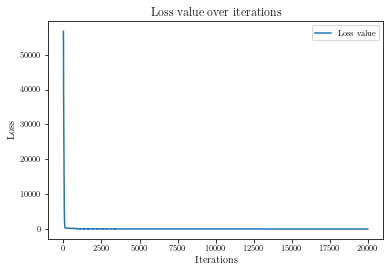

In [5]:
# The class PINN is initialized by using the standard init function from object
# oriented python. There are a total of 7 variables fed to initialize:
#
# Inputs:
# x (distance from the shock or through the 1D nozzle length)
# t (time)
#
# Outputs:
# rho (density at x,t),
# u (speed at x,t),
# p (pressure at x,t),
# E (specific energy at x,t),
# layers (layers vector).
#
# We are providing x and t as inputs to the NN and output is P, rho, u, E
#
# X is the net input matrix which is formed by concatenating x and t for the
# training data point. Additional '1' is concatenated for incorporating bias terms.
#
# lb and ub are the lower and upper bound respectively of X which would be later
# used to normalize the value of X before passing it onto the neural network.
# This is done to avoid explosion of network output values due to large training
# data values of X.

# Main function, inside which there are the training and testing commands.
if __name__ == "__main__":

    # Neural Network Architecture
    # layers is a vector of all the node in each of the neural network layers
    # First value, 2 respresents the input layer with 2 parameters while
    # last value 4 is the number of outputs desired
    #layers = [2, 10, 25, 15, 4]
    layers = [2, 20, 20, 20, 20, 20, 20, 20, 4] # NICE!
    #layers = [2, 40, 40, 40, 40, 4]

    # Load Data
    # The Fortran generated data was stored in file name 'datashcok1d.txt', which
    # is read by numpy and stored as a new variable by name data.
    #data = np.loadtxt('data/datashock1d.txt') # too big
    data = np.loadtxt('data/datashock1d001.txt')
    #data = np.loadtxt('data/datashock1dlite.txt') # too small

    # The training set length N_train is taken to be 85% of the entire dataset.
    # The rest 15% will be used as test set to validate the result of the training.
    N_train = int(0.85*data.shape[0])

    # idx is a random numbers vector, which will be used to randomly pick 85% of
    # the data from the dataset.
    idx = np.random.choice(range(data.shape[0]), size=(N_train,), replace=False)

    # The rest is mere slicing of dataset to get all required parameters.
    # x
    x_train  = data[idx,0:1].flatten()[:,None]
    t_train  = data[idx,1:2].flatten()[:,None]
    XT_train = np.concatenate([x_train, t_train], 1)
    #X, T    = np.meshgrid(x_train,t_train)
    # y
    rho_train = data[idx,2:3].flatten()[:,None]
    u_train   = data[idx,3:4].flatten()[:,None]
    p_train   = data[idx,4:5].flatten()[:,None]
    E_train   = data[idx,5:6].flatten()[:,None]

    # Training the NN based on the training set, randomly chosen above model
    # = PINN(..) passes the necessary training data to the 'NN' class (model
    # here being an instance of the NN class) in order to initialize all the
    # parameters as well as the NN architecture including random initialization
    # of weights and biases.
    model = PINN(x_train, t_train, rho_train, u_train, p_train, E_train, layers)
    model.train(20000) 
    
    #model.train2(num_epochs = 200, batch_size = 10000, learning_rate=1e-3)                                                           
    #model.train2(num_epochs = 300, batch_size = 10000, learning_rate=1e-4)                                                           
    #model.train2(num_epochs = 300, batch_size = 10000, learning_rate=1e-5)                                                           
    #model.train2(num_epochs = 200, batch_size = 10000, learning_rate=1e-6)
    
    # Plotting Loss
    plt.plot(loss_vector, label='Loss value')
    plt.legend()
    plt.title('Loss value over iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    savefig('./figures/Loss', crop = False)
    plt.show()

    # Test Data
    # Test the neural network performance using Test dataset "data1" generated
    # by eliminating the initally randomly selected rows from the data. The test
    # dataset "data1" is then sliced to get test parameter values.
    data1 = data
    data1 = np.delete(data1, idx, 0)
    # x
    x_test  = data1[:,0:1].flatten()[:,None]
    t_test  = data1[:,1:2].flatten()[:,None]
    XT_test = np.concatenate([x_test, t_test], 1)
    # y
    rho_test = data1[:,2:3].flatten()[:,None]
    u_test   = data1[:,3:4].flatten()[:,None]
    p_test   = data1[:,4:5].flatten()[:,None]
    E_test   = data1[:,5:6].flatten()[:,None]

    # Prediction
    # The input parameters of the test set are used to predict the pressure,
    # density, speed and specific energy for the given x and t by using the
    # .predict method.
    rho_pred, u_pred, p_pred, E_pred = model.predict(x_test, t_test)

    #RHO_pred = griddata(x_test, rho_pred.flatten(), (X, T), method='cubic')

In [6]:
    # Error
    # Normal relative error is printed for each variable
    error_rho = np.linalg.norm(rho_test-rho_pred,2)/np.linalg.norm(rho_test,2)
    error_u = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    error_p = np.linalg.norm(p_test-p_pred,2)/np.linalg.norm(p_test,2)
    error_E = np.linalg.norm(E_test-E_pred,2)/np.linalg.norm(E_test,2)
    print("Test Error in rho: "+str(error_rho))
    print("Test Error in u: "+str(error_u))
    print("Test Error in p: "+str(error_p))
    print("Test Error in E: "+str(error_E))
    
    #errors = np.sqrt((Y_test-Y_pred)**2/Y_test**2)                                                                                  
    #mean_errors = np.mean(errors,0)                                                                                                 
    #std_errors = np.std(errors,0)

    #Plotting
    #a = 201
    #for i in range (0, 3046, 1608):
    #plt.plot(x_test[0:3046:a], rho_pred[0:3046:a], 'm', label='NN')
    #plt.plot(x_test[0:3046:a], rho_test[0:3046:a], 'g', label='Exact')
    #plt.title('Comparison of NN and Exact solution for Density')
    #plt.xlabel('x')
    #plt.ylabel('value')
    #plt.legend()
    #plt.show()
    #savefig('./figures/Error', crop = False)

Test Error in rho: 0.005815189687535378
Test Error in u: 0.00027176635246904657
Test Error in p: 0.0003669256449419307
Test Error in E: 0.006151926605244981


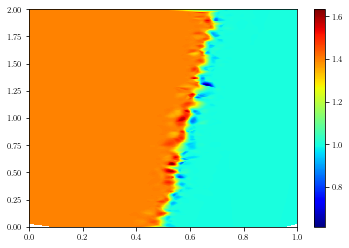

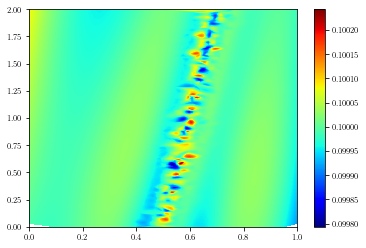

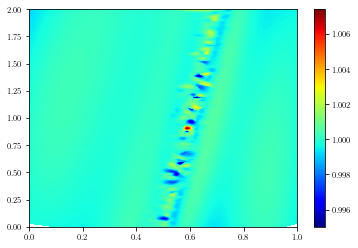

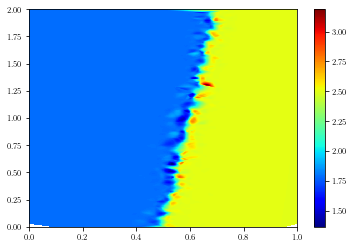

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


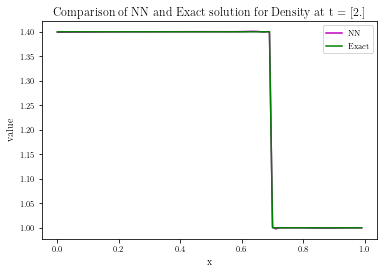

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


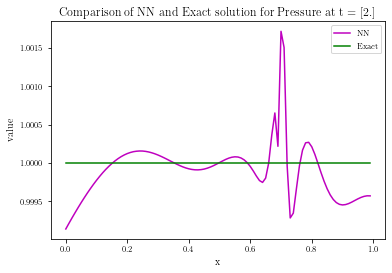

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


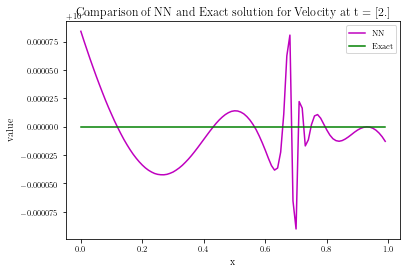

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


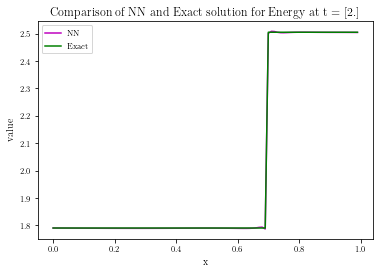

In [7]:
    # Plotting
    plot_solution(XT_test, rho_pred, 1)
    savefig('./figures/rho_pred', crop = False)
    plt.show()   
    plot_solution(XT_test, u_pred, 1)
    savefig('./figures/u_pred', crop = False)
    plt.show()   
    plot_solution(XT_test, p_pred, 1)
    savefig('./figures/p_pred', crop = False)
    plt.show()   
    plot_solution(XT_test, E_pred, 1)
    savefig('./figures/E_pred', crop = False)
    plt.show()   

    # Predict for plotting
    #lb = XT_test.min(0)
    #ub = XT_test.max(0)
    #nn = 100
    #x = np.linspace(lb[0], ub[0], nn)
    #t = np.linspace(lb[1], ub[1], nn)
    #X, T = np.meshgrid(x,t)

    #RR_star = griddata(XT_test, rho_pred.flatten(), (X, T), method='cubic')
    #UU_star = griddata(XT_test, u_pred.flatten(),   (X, T), method='cubic')
    #PP_star = griddata(XT_test, p_pred.flatten(),   (X, T), method='cubic')
    #EE_star = griddata(XT_test, E_pred.flatten(),   (X, T), method='cubic')

#    ############################# Plotting ###############################
#
#    fig, ax = newfig(1.0, 1.4)
#    ax.axis('off')
#
#    ####### Row 0: rho(t,x) ##################
#    gs0 = gridspec.GridSpec(1, 2)
#    gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
#    ax = plt.subplot(gs0[:, :])
#
#    h = ax.imshow(RR_star.T, interpolation='nearest', cmap='rainbow',
#                  #extent=[lb[0], ub[0], lb[1], ub[1]], #t_test.min(),t_test.max()
#                  #extent=[lb[1], ub[1], lb[0], ub[0]], #t_test.min(),t_test.max()
#                  extent=[t_test.min(),t_test.max(), lb[0], ub[0]],
#                  origin='lower', aspect='auto')
#    divider = make_axes_locatable(ax)
#    cax = divider.append_axes("right", size="5%", pad=0.05)
#    fig.colorbar(h, cax=cax)
#
#    ax.plot(XT_train[:,0], XT_train[:,1], 'kx', label = 'Data (%d points)' % (rho_train.shape[0]), markersize = 2, clip_on = False)
#
#    line = np.linspace(x_train.min(), x_train.max(), 2)[:,None]
#    #ax.plot(t_test[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
#    #ax.plot(t_test[15]*np.ones((2,1)), line, 'w-', linewidth = 1)
#    #ax.plot(t_test[30]*np.ones((2,1)), line, 'w-', linewidth = 1)
#
#    ax.set_xlabel('$x$')
#    ax.set_ylabel('$t$')
#    ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
#    #leg = ax.legend(frameon=False, loc = 'best')
#    #plt.setp(leg.get_texts(), color='w')
#    ax.set_title(r'$\rho(x,t)$', fontsize = 10)
#
#    ####### Row 1: rho(t,x) slices ##################
#    gs1 = gridspec.GridSpec(1, 4)
#    gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)
#
#    ax = plt.subplot(gs1[0, 0])
#    # ax.plot(x_test,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')
#    # ax.plot(x_test,rho_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
#    ax.set_xlabel('$x$')
#    ax.set_ylabel('Density')
#    ax.set_title('$t = 2.0$', fontsize = 10)
#    ax.axis('square')
#    ax.set_xlim([0.0,1.0])
#    ax.set_ylim([0.0,2.0])
#
#    ax = plt.subplot(gs1[0, 1])
#    # ax.plot(x_test,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')
#    # ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
#    ax.set_xlabel('$x$')
#    ax.set_ylabel('Velocity')
#    ax.axis('square')
#    ax.set_xlim([0.0,1.0])
#    ax.set_ylim([0.0,2.0])
#    ax.set_title('$t = 2.0$', fontsize = 10)
#    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
#
#    ax = plt.subplot(gs1[0, 2])
#    #ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')
#    #ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
#    ax.set_xlabel('$x$')
#    ax.set_ylabel('Pressure')
#    ax.axis('square')
#    ax.set_xlim([0.0,1.0])
#    ax.set_ylim([0.0, 2.0])
#    ax.set_title('$t = 2.0$', fontsize = 10)
#
#    ax = plt.subplot(gs1[0, 3])
#    # ax.plot(x_test,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')
#    # ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
#    ax.set_xlabel('$x$')
#    ax.set_ylabel('Energy')
#    ax.axis('square')
#    ax.set_xlim([0.0,1.0])
#    ax.set_ylim([0.0,2.0])
#    ax.set_title('$t = 2.0$', fontsize = 10)
#    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
#
#    savefig('./figures/Euler_identification')

    # Visualize and compare the results against CFD generated outputs: plt_u and
    # plt_l are the upper and lower bounds of a visualizing window respectively.
    # This defines a specific set of inputs for which the results will be plotted.
    # Again, we predict the output values for the specific input window. We now
    # plot the predicted ouputs by the network against the exact solution values 
    # by CFD using matplotlib

    # x
    x_test_plt  = data[:, 0:1].flatten()[:,None]
    t_test_plt  = data[:, 1:2].flatten()[:,None]
    
    # y
    rho_test_plt = data[:, 2:3].flatten()[:,None]
    u_test_plt   = data[:, 3:4].flatten()[:,None]
    p_test_plt   = data[:, 4:5].flatten()[:,None]
    E_test_plt   = data[:, 5:6].flatten()[:,None]

    # Prediction (for plotting)
    rho_pred_plt, u_pred_plt, p_pred_plt, E_pred_plt = model.predict(x_test_plt, t_test_plt)
    
    # Note that these value should be changed if using a different dataset or a different time
    c = 1
    b = 200*c
    a = 201
    
    # Plot RHO
    plt.plot(x_test_plt[0+b:len(x_test_plt)-1:a], rho_pred_plt[0+b:len(x_test_plt)-1:a], 'm', label='NN')
    plt.plot(x_test_plt[0+b:len(x_test_plt)-1:a], rho_test_plt[0+b:len(x_test_plt)-1:a], 'g', label='Exact')
    plt.title('Comparison of NN and Exact solution for Density at t = ' +str(t_test_plt[b]))
    plt.xlabel('x')
    plt.ylabel('value')
    plt.legend()
    savefig('./figures/predictedRHO', crop = False)
    plt.show()
    
    # Plot P
    plt.plot(x_test_plt[0+b:len(x_test_plt)-1:a], p_pred_plt[0+b:len(x_test_plt)-1:a], 'm', label='NN')
    plt.plot(x_test_plt[0+b:len(x_test_plt)-1:a], p_test_plt[0+b:len(x_test_plt)-1:a], 'g', label='Exact')
    plt.title('Comparison of NN and Exact solution for Pressure at t = ' +str(t_test_plt[b]))
    plt.xlabel('x')
    plt.ylabel('value')
    plt.legend()
    savefig('./figures/predictedP', crop = False)
    plt.show()

    # Plot U
    plt.plot(x_test_plt[0+b:len(x_test_plt)-1:a], u_pred_plt[0+b:len(x_test_plt)-1:a], 'm', label='NN')
    plt.plot(x_test_plt[0+b:len(x_test_plt)-1:a], u_test_plt[0+b:len(x_test_plt)-1:a], 'g', label='Exact')
    plt.title('Comparison of NN and Exact solution for Velocity at t = ' +str(t_test_plt[b]))
    plt.xlabel('x')
    plt.ylabel('value')
    plt.legend()
    savefig('./figures/predictedU', crop = False)
    plt.show()
    
    # Plot E
    plt.plot(x_test_plt[0+b:len(x_test_plt)-1:a], E_pred_plt[0+b:len(x_test_plt)-1:a], 'm', label='NN')
    plt.plot(x_test_plt[0+b:len(x_test_plt)-1:a], E_test_plt[0+b:len(x_test_plt)-1:a], 'g', label='Exact')
    plt.title('Comparison of NN and Exact solution for Energy at t = ' +str(t_test_plt[b]))
    plt.xlabel('x')
    plt.ylabel('value')
    plt.legend()
    savefig('./figures/predictedE', crop = False)
    plt.show()